✅ Successfully loaded artifacts from: RC_Tank_Env_scalers.zip
Epoch 1/1000, Train Loss: 0.2690, Val Loss: 0.2273
Epoch 2/1000, Train Loss: 0.2663, Val Loss: 0.2252
Epoch 3/1000, Train Loss: 0.2645, Val Loss: 0.2231
Epoch 4/1000, Train Loss: 0.2619, Val Loss: 0.2210
Epoch 5/1000, Train Loss: 0.2600, Val Loss: 0.2190
Epoch 6/1000, Train Loss: 0.2580, Val Loss: 0.2169
Epoch 7/1000, Train Loss: 0.2558, Val Loss: 0.2149
Epoch 8/1000, Train Loss: 0.2533, Val Loss: 0.2128
Epoch 9/1000, Train Loss: 0.2511, Val Loss: 0.2108
Epoch 10/1000, Train Loss: 0.2489, Val Loss: 0.2088
Epoch 11/1000, Train Loss: 0.2468, Val Loss: 0.2068
Epoch 12/1000, Train Loss: 0.2445, Val Loss: 0.2048
Epoch 13/1000, Train Loss: 0.2423, Val Loss: 0.2028
Epoch 14/1000, Train Loss: 0.2406, Val Loss: 0.2009
Epoch 15/1000, Train Loss: 0.2380, Val Loss: 0.1989
Epoch 16/1000, Train Loss: 0.2365, Val Loss: 0.1969
Epoch 17/1000, Train Loss: 0.2336, Val Loss: 0.1950
Epoch 18/1000, Train Loss: 0.2318, Val Loss: 0.1931
Epoch 19/10

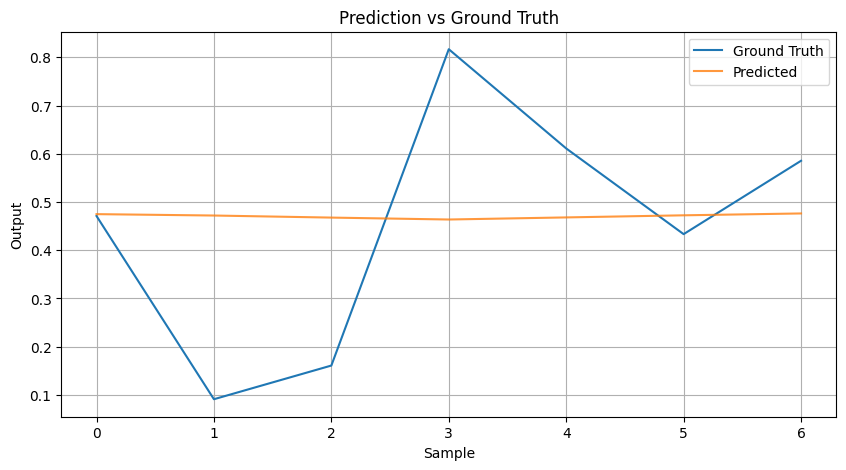

In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import zipfile
import joblib
import yaml
import io
import warnings

# =============================================================================
# Helper Functions and Classes (from uploaded files)
# =============================================================================

class ScalingZipLoader:
    def __init__(self, zip_path: str | Path):
        self.zip_path = Path(zip_path)
        self.scaler_in = None
        self.scaler_out = None
        self.metadata = None

        if not self.zip_path.exists():
            raise FileNotFoundError(f"❌ ZIP file not found at: {self.zip_path}")
        self._load_from_zip()
        print(f"✅ Successfully loaded artifacts from: {self.zip_path.name}")

    def _load_from_zip(self):
        with zipfile.ZipFile(self.zip_path, "r") as zipf:
            self.scaler_in = self._load_joblib_from_zip(zipf, "input_scaler.pkl")
            self.scaler_out = self._load_joblib_from_zip(zipf, "output_scaler.pkl")
            self.metadata = self._load_yaml_from_zip(zipf, "metadata.yaml")

    def _load_joblib_from_zip(self, zipf, filename):
        with zipf.open(filename) as f:
            with io.BytesIO(f.read()) as bio:
                return joblib.load(bio)

    def _load_yaml_from_zip(self, zipf, filename):
        with zipf.open(filename) as f:
            return yaml.safe_load(f)

    def transform_input(self, data):
        return self.scaler_in.transform(data)

    def inverse_transform_input(self, data):
        return self.scaler_in.inverse_transform(data)

    def transform_output(self, data):
        return self.scaler_out.transform(data)

    def inverse_transform_output(self, data):
        return self.scaler_out.inverse_transform(data)

    def summary(self):
        print("="*50)
        print("          Scaling Loader Summary")
        print("="*50)
        print(f"Loaded from: {self.zip_path.name}")
        if self.metadata:
            print("\nMetadata:")
            print(yaml.dump(self.metadata, indent=2))
        else:
            print("\nNo metadata found.")
        print("="*50)


def create_sequences(data: np.ndarray, window_size: int):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:(i + window_size)])
        y.append(data[i + window_size, 1])
    return np.array(X), np.array(y)


class LSTM_MODEL(nn.Module):
    def __init__(self, input_dim, hidden_dim=64, num_layers=2, output_dim=1, dropout=0.1):
        super(LSTM_MODEL, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.lstm = nn.LSTM(
            input_size=input_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0
        )
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])
        return out

class Logger:
    def __init__(self):
        self.df = pd.DataFrame()

    def add_data_log(self, columns_name, data_list):
        new_data = {col: data for col, data in zip(columns_name, data_list)}
        if self.df.empty:
            self.df = pd.DataFrame(new_data)
        else:
            new_rows = pd.DataFrame(new_data)
            self.df = pd.concat([self.df, new_rows], ignore_index=True)

# =============================================================================
# Main Pipeline Class
# =============================================================================

class LSTMTrainingPipeline:
    def __init__(self,
                 data_folder,
                 scaler_zip,
                 model_save_path,
                 window_size=30,
                 batch_size=64,
                 hidden_dim=128,
                 num_layers=2,
                 lr=1e-3,
                 num_epochs=100,
                 patience=20,
                 device=None):
        self.data_folder = Path(data_folder)
        self.scaler_loader = ScalingZipLoader(scaler_zip)
        self.window_size = window_size
        self.batch_size = batch_size
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.lr = lr
        self.num_epochs = num_epochs
        self.patience = patience
        self.model_save_path = Path(model_save_path)
        self.device = device or ("cuda" if torch.cuda.is_available() else "cpu")
        self.logger = Logger()
        self.model = None
        self.train_loader = None
        self.val_loader = None
        self.test_loader = None

    def prepare_data(self):
        csv_files = list(self.data_folder.glob("*.csv"))
        if not csv_files:
            raise FileNotFoundError(f"No CSV files in {self.data_folder}")

        X_all, y_all = [], []
        for f in csv_files:
            df = pd.read_csv(f)
            X_scaled = self.scaler_loader.transform_input(df.iloc[:, 0:1].values)
            y_scaled = self.scaler_loader.transform_output(df.iloc[:, 1:2].values) # Corrected to use transform_output
            data = np.column_stack((X_scaled, y_scaled))
            X_seq, y_seq = create_sequences(data, self.window_size)
            X_all.append(X_seq)
            y_all.append(y_seq)

        X_all = np.concatenate(X_all, axis=0)
        y_all = np.concatenate(y_all, axis=0)

        n_total = len(X_all)
        n_test = int(0.1 * n_total)
        n_val = int(0.1 * n_total)
        n_train = n_total - n_test - n_val

        train_dataset = TensorDataset(torch.tensor(X_all[:n_train], dtype=torch.float32),
                                      torch.tensor(y_all[:n_train], dtype=torch.float32).unsqueeze(1)) # Added unsqueeze
        val_dataset = TensorDataset(torch.tensor(X_all[n_train:n_train+n_val], dtype=torch.float32),
                                    torch.tensor(y_all[n_train:n_train+n_val], dtype=torch.float32).unsqueeze(1)) # Added unsqueeze
        test_dataset = TensorDataset(torch.tensor(X_all[-n_test:], dtype=torch.float32),
                                     torch.tensor(y_all[-n_test:], dtype=torch.float32).unsqueeze(1)) # Added unsqueeze

        self.train_loader = DataLoader(train_dataset, batch_size=self.batch_size, shuffle=True)
        self.val_loader = DataLoader(val_dataset, batch_size=self.batch_size, shuffle=False)
        self.test_loader = DataLoader(test_dataset, batch_size=self.batch_size, shuffle=False)

    def build_model(self):
        input_dim = self.train_loader.dataset.tensors[0].shape[2]
        self.model = LSTM_MODEL(input_dim=input_dim,
                                hidden_dim=self.hidden_dim,
                                num_layers=self.num_layers,
                                output_dim=1).to(self.device)

    def train(self):
        criterion = nn.MSELoss()
        optimizer = torch.optim.Adam(self.model.parameters(), lr=self.lr)
        best_val_loss = float('inf')
        patience_counter = 0

        for epoch in range(self.num_epochs):
            self.model.train()
            for X_batch, y_batch in self.train_loader:
                X_batch, y_batch = X_batch.to(self.device), y_batch.to(self.device)
                optimizer.zero_grad()
                outputs = self.model(X_batch)
                loss = criterion(outputs, y_batch)
                loss.backward()
                optimizer.step()

            val_loss = self.evaluate(self.val_loader)
            print(f"Epoch {epoch+1}/{self.num_epochs}, Train Loss: {loss.item():.4f}, Val Loss: {val_loss:.4f}")

            if val_loss < best_val_loss:
                best_val_loss = val_loss
                torch.save(self.model.state_dict(), self.model_save_path)
                patience_counter = 0
            else:
                patience_counter += 1
                if patience_counter >= self.patience:
                    print("Early stopping")
                    break
        self.model.load_state_dict(torch.load(self.model_save_path))

    def evaluate(self, data_loader):
        self.model.eval()
        total_loss = 0
        criterion = nn.MSELoss()
        with torch.no_grad():
            for X_batch, y_batch in data_loader:
                X_batch, y_batch = X_batch.to(self.device), y_batch.to(self.device)
                outputs = self.model(X_batch)
                loss = criterion(outputs, y_batch)
                total_loss += loss.item()
        return total_loss / len(data_loader)

    def predict(self, data_loader):
        self.model.eval()
        predictions = []
        with torch.no_grad():
            for X_batch, _ in data_loader:
                X_batch = X_batch.to(self.device)
                outputs = self.model(X_batch)
                predictions.append(outputs.cpu().numpy())
        return np.concatenate(predictions)

    def plot_predictions(self, save_path=None):
        preds = self.predict(self.test_loader)
        targets = self.test_loader.dataset.tensors[1].numpy()
        preds = self.scaler_loader.inverse_transform_output(preds)
        targets = self.scaler_loader.inverse_transform_output(targets)

        plt.figure(figsize=(10, 5))
        plt.plot(targets, label="Ground Truth")
        plt.plot(preds, label="Predicted", alpha=0.8)
        plt.xlabel("Sample")
        plt.ylabel("Output")
        plt.title("Prediction vs Ground Truth")
        plt.legend()
        plt.grid(True)
        if save_path:
            plt.savefig(save_path)
        plt.show()

    def run(self,path_file):
        self.prepare_data()
        self.build_model()
        self.train()
        test_loss = self.evaluate(self.test_loader)
        print(f"Test Loss: {test_loss:.4f}")
        self.plot_predictions(path_file)


if __name__ == "__main__":
    # You need to adjust these paths to your local machine
    DATA_FOLDER = Path("./data/raw")
    SCALER_ZIP = Path("./config/RC_Tank_Env_scalers.zip")
    MODEL_SAVE = Path("./models/lstm_model.pth")
    PATH_FILE = Path(r"D:\Project_end\New_world\my_project\notebooks\logs\1.png")
    
    # Create dummy data and scaler for testing if they don't exist
    if not DATA_FOLDER.exists():
        DATA_FOLDER.mkdir(parents=True)
        pd.DataFrame({'PWM_duty': np.random.rand(100), 'Tank_level': np.random.rand(100)}).to_csv(DATA_FOLDER / 'dummy_data.csv', index=False)
        
    if not SCALER_ZIP.parent.exists():
        SCALER_ZIP.parent.mkdir(parents=True)

    if not SCALER_ZIP.exists():
        from sklearn.preprocessing import MinMaxScaler
        import zipfile
        import joblib
        import yaml

        # Create dummy scalers
        scaler_in = MinMaxScaler()
        scaler_out = MinMaxScaler()
        dummy_data = np.random.rand(100, 2)
        scaler_in.fit(dummy_data[:, 0].reshape(-1, 1))
        scaler_out.fit(dummy_data[:, 1].reshape(-1, 1))

        # Save scalers and metadata to a zip file
        with zipfile.ZipFile(SCALER_ZIP, 'w') as zf:
            joblib.dump(scaler_in, 'input_scaler.pkl')
            joblib.dump(scaler_out, 'output_scaler.pkl')
            with open('input_scaler.pkl', 'rb') as f:
                zf.writestr('input_scaler.pkl', f.read())
            with open('output_scaler.pkl', 'rb') as f:
                zf.writestr('output_scaler.pkl', f.read())

            metadata = {'input_features': ['PWM_duty'], 'output_features': ['Tank_level']}
            with open('metadata.yaml', 'w') as f:
                yaml.dump(metadata, f)
            with open('metadata.yaml', 'r') as f:
                zf.writestr('metadata.yaml', f.read())

    if not MODEL_SAVE.parent.exists():
        MODEL_SAVE.parent.mkdir(parents=True)


    pipeline = LSTMTrainingPipeline(
        data_folder=DATA_FOLDER,
        scaler_zip=SCALER_ZIP,
        model_save_path=MODEL_SAVE,
        window_size=30, # Reduced for dummy data
        batch_size=15000,
        hidden_dim=64,
        num_layers=2,
        lr=1e-4,
        num_epochs=1000,
        patience=50,
    )
    pipeline.run(PATH_FILE)

d:\Project_end\New_world\NEW_WORLD_SETUP\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


Epoch 1/50 | Train Loss: 0.1313 | Val Loss: 0.0655
Epoch 2/50 | Train Loss: 0.0589 | Val Loss: 0.0489
Epoch 3/50 | Train Loss: 0.0423 | Val Loss: 0.0321
Epoch 4/50 | Train Loss: 0.0236 | Val Loss: 0.0103
Epoch 5/50 | Train Loss: 0.0082 | Val Loss: 0.0066
Epoch 6/50 | Train Loss: 0.0048 | Val Loss: 0.0026
Epoch 7/50 | Train Loss: 0.0022 | Val Loss: 0.0025
Epoch 8/50 | Train Loss: 0.0025 | Val Loss: 0.0027
Epoch 9/50 | Train Loss: 0.0022 | Val Loss: 0.0021
Epoch 10/50 | Train Loss: 0.0023 | Val Loss: 0.0018
Epoch 11/50 | Train Loss: 0.0022 | Val Loss: 0.0018
Epoch 12/50 | Train Loss: 0.0021 | Val Loss: 0.0018
Epoch 13/50 | Train Loss: 0.0021 | Val Loss: 0.0020
Epoch 14/50 | Train Loss: 0.0023 | Val Loss: 0.0020
Epoch 15/50 | Train Loss: 0.0021 | Val Loss: 0.0018
Epoch 16/50 | Train Loss: 0.0021 | Val Loss: 0.0018
Epoch 17/50 | Train Loss: 0.0020 | Val Loss: 0.0018
Epoch 18/50 | Train Loss: 0.0020 | Val Loss: 0.0019
Epoch 19/50 | Train Loss: 0.0020 | Val Loss: 0.0018
Epoch 20/50 | Train L

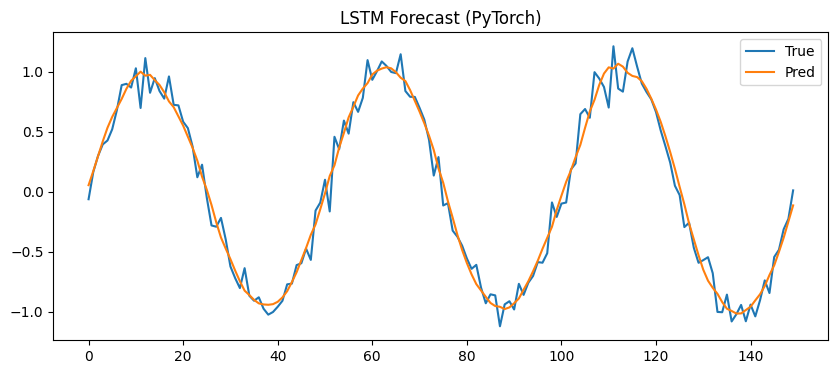

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader


# 1) สร้างข้อมูลสังเคราะห์ (sine wave + noise)
def make_sine_data(n_points=1200, noise_std=0.1, freq=0.02, seed=42):
    np.random.seed(seed)
    x = np.arange(n_points)
    y = np.sin(2 * np.pi * freq * x) + np.random.normal(scale=noise_std, size=n_points)
    return y

# 2) ฟังก์ชันสร้าง sequence
class SequenceDataset(Dataset):
    def __init__(self, series, window_size):
        X, y = [], []
        for i in range(len(series) - window_size):
            X.append(series[i:i + window_size])
            y.append(series[i + window_size])
        self.X = torch.tensor(np.array(X), dtype=torch.float32).unsqueeze(-1)
        self.y = torch.tensor(np.array(y), dtype=torch.float32).unsqueeze(-1)
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# 3) โมเดล LSTM class
class LSTMForecast(nn.Module):
    def __init__(self, input_dim=1, hidden_dim=64, num_layers=1, dropout=0.2):
        super().__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers=num_layers, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_dim, 1)
    def forward(self, x):
        out, _ = self.lstm(x)
        out = out[:, -1, :]  # ใช้ output ของ timestep สุดท้าย
        out = self.fc(out)
        return out

if __name__ == '__main__':
    # Parameters
    WINDOW = 50
    TEST_SIZE = 200
    VAL_SIZE = 200
    EPOCHS = 50
    BATCH = 32
    LR = 1e-3
    DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

    # สร้างข้อมูลและ scaling
    series = make_sine_data()
    scaler = MinMaxScaler()
    series_scaled = scaler.fit_transform(series.reshape(-1,1)).flatten()

    # แบ่ง train/val/test
    train_series = series_scaled[: - (VAL_SIZE + TEST_SIZE)]
    val_series = series_scaled[- (VAL_SIZE + TEST_SIZE) : -TEST_SIZE]
    test_series = series_scaled[-TEST_SIZE:]

    train_ds = SequenceDataset(train_series, WINDOW)
    val_ds = SequenceDataset(val_series, WINDOW)
    test_ds = SequenceDataset(test_series, WINDOW)

    train_loader = DataLoader(train_ds, batch_size=BATCH, shuffle=True)
    val_loader = DataLoader(val_ds, batch_size=BATCH)

    # สร้างโมเดล
    model = LSTMForecast().to(DEVICE)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=LR)

    # Train loop
    best_val = np.inf
    for epoch in range(EPOCHS):
        model.train()
        train_loss = 0
        for X, y in train_loader:
            X, y = X.to(DEVICE), y.to(DEVICE)
            optimizer.zero_grad()
            pred = model(X)
            loss = criterion(pred, y)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * len(X)
        train_loss /= len(train_loader.dataset)

        # Validation
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for X, y in val_loader:
                X, y = X.to(DEVICE), y.to(DEVICE)
                pred = model(X)
                val_loss += criterion(pred, y).item() * len(X)
        val_loss /= len(val_loader.dataset)

        print(f'Epoch {epoch+1}/{EPOCHS} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}')

        if val_loss < best_val:
            best_val = val_loss
            torch.save(model.state_dict(), 'best_lstm.pth')

    # ประเมินบน test set
    model.load_state_dict(torch.load('best_lstm.pth'))
    model.eval()
    X_test, y_test = test_ds.X.to(DEVICE), test_ds.y.to(DEVICE)
    with torch.no_grad():
        preds = model(X_test).cpu().numpy().flatten()

    preds_inv = scaler.inverse_transform(preds.reshape(-1,1)).flatten()
    y_true = scaler.inverse_transform(y_test.cpu().numpy().reshape(-1,1)).flatten()

    mae = mean_absolute_error(y_true, preds_inv)
    rmse = np.sqrt(mean_squared_error(y_true, preds_inv))
    print(f'Test MAE: {mae:.4f}, RMSE: {rmse:.4f}')

    # Plot
    plt.figure(figsize=(10,4))
    plt.plot(y_true, label='True')
    plt.plot(preds_inv, label='Pred')
    plt.legend()
    plt.title('LSTM Forecast (PyTorch)')
    plt.show()

Epoch 001 | Train: 0.878347 | Val: 1.004041
Epoch 002 | Train: 0.309970 | Val: 0.200718
Epoch 003 | Train: 0.121826 | Val: 0.120944
Epoch 004 | Train: 0.095124 | Val: 0.090963
Epoch 005 | Train: 0.087277 | Val: 0.110567
Epoch 006 | Train: 0.088754 | Val: 0.089729
Epoch 007 | Train: 0.095175 | Val: 0.099652
Epoch 008 | Train: 0.093525 | Val: 0.101209
Epoch 009 | Train: 0.086946 | Val: 0.086367
Epoch 010 | Train: 0.084464 | Val: 0.087918
Epoch 011 | Train: 0.083611 | Val: 0.104877
Epoch 012 | Train: 0.084928 | Val: 0.087692
Epoch 013 | Train: 0.085428 | Val: 0.118444
Epoch 014 | Train: 0.085097 | Val: 0.084411
Epoch 015 | Train: 0.084215 | Val: 0.086868
Epoch 016 | Train: 0.085625 | Val: 0.084635
Epoch 017 | Train: 0.084314 | Val: 0.096647
Epoch 018 | Train: 0.083723 | Val: 0.106998
Epoch 019 | Train: 0.081696 | Val: 0.113553
Epoch 020 | Train: 0.083331 | Val: 0.090697
Epoch 021 | Train: 0.085870 | Val: 0.083904
Epoch 022 | Train: 0.083932 | Val: 0.114865
Epoch 023 | Train: 0.083324 | Va

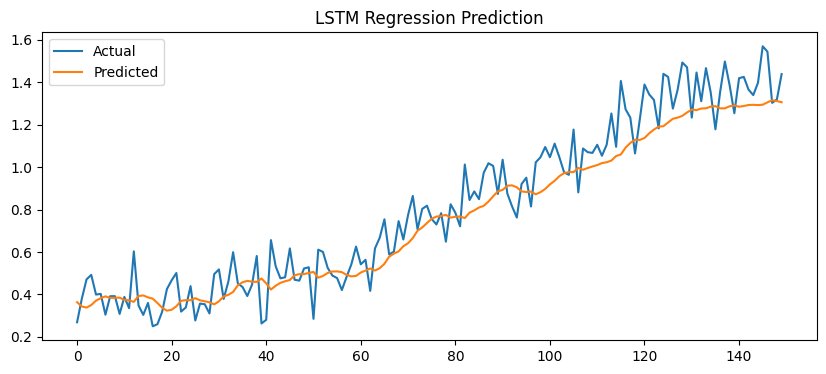

In [3]:
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

# -----------------------------
# 1. Dataset class
# -----------------------------
class SequenceDataset(Dataset):
    def __init__(self, data, seq_len=30, target_len=1):
        if data.ndim == 1:
            data = data.reshape(-1, 1)
        self.X = []
        self.y = []
        N = len(data)
        for i in range(N - seq_len - target_len + 1):
            self.X.append(data[i : i + seq_len])
            self.y.append(data[i + seq_len : i + seq_len + target_len])
        self.X = np.stack(self.X).astype(np.float32)
        self.y = np.stack(self.y).astype(np.float32)
        if target_len == 1 and self.y.shape[-1] == 1:
            self.y = self.y.reshape(len(self.y), 1)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return torch.from_numpy(self.X[idx]), torch.from_numpy(self.y[idx])

# -----------------------------
# 2. LSTM Model
# -----------------------------
class LSTMRegressor(nn.Module):
    def __init__(self, input_size, hidden_size, output_size=1,
                 num_layers=1, dropout=0.0, bidirectional=False):
        super().__init__()
        self.num_directions = 2 if bidirectional else 1
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers=num_layers,
                            batch_first=True, dropout=dropout, bidirectional=bidirectional)
        self.fc = nn.Linear(hidden_size * self.num_directions, output_size)

    def forward(self, x):
        out, (h_n, c_n) = self.lstm(x)
        last = out[:, -1, :]
        return self.fc(last)

# -----------------------------
# 3. Training function
# -----------------------------
def train_model(model, train_loader, val_loader, device,
                n_epochs=100, lr=1e-3, weight_decay=0.0,
                patience=10):
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    # ---- แก้ตรงนี้ ----
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=5, factor=0.5)
    # --------------------
    loss_fn = nn.MSELoss()

    best_val = float('inf')
    best_state = None
    epochs_no_improve = 0

    for epoch in range(1, n_epochs + 1):
        model.train()
        train_losses = []
        for xb, yb in train_loader:
            xb, yb = xb.to(device).float(), yb.to(device).float()
            optimizer.zero_grad()
            pred = model(xb)
            loss = loss_fn(pred, yb)
            loss.backward()
            optimizer.step()
            train_losses.append(loss.item())

        model.eval()
        val_losses = []
        with torch.no_grad():
            for xb, yb in val_loader:
                xb, yb = xb.to(device).float(), yb.to(device).float()
                pred = model(xb)
                val_losses.append(loss_fn(pred, yb).item())

        avg_train = np.mean(train_losses)
        avg_val = np.mean(val_losses)
        scheduler.step(avg_val)

        print(f"Epoch {epoch:03d} | Train: {avg_train:.6f} | Val: {avg_val:.6f}")

        if avg_val < best_val - 1e-6:
            best_val = avg_val
            best_state = {k: v.cpu() for k, v in model.state_dict().items()}
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= patience:
                print("Early stopping.")
                break

    if best_state:
        model.load_state_dict(best_state)
    return model


# -----------------------------
# 4. Evaluation and Plot
# -----------------------------
def evaluate_and_plot(model, loader, scaler_y=None, device='cpu'):
    model.eval()
    preds = []
    trues = []
    with torch.no_grad():
        for xb, yb in loader:
            xb = xb.to(device).float()
            p = model(xb).cpu().numpy()
            preds.append(p)
            trues.append(yb.numpy())
    preds = np.vstack(preds)
    trues = np.vstack(trues)

    if scaler_y is not None:
        preds = scaler_y.inverse_transform(preds)
        trues = scaler_y.inverse_transform(trues)

    mse = mean_squared_error(trues, preds)
    mae = mean_absolute_error(trues, preds)
    r2 = r2_score(trues, preds)
    print(f"\n--- Evaluation ---")
    print(f"MSE: {mse:.6f}")
    print(f"MAE: {mae:.6f}")
    print(f"R² : {r2:.4f}")

    plt.figure(figsize=(10,4))
    plt.plot(trues, label='Actual')
    plt.plot(preds, label='Predicted')
    plt.legend()
    plt.title('LSTM Regression Prediction')
    plt.show()

# -----------------------------
# 5. Main script
# -----------------------------
if __name__ == "__main__":
    # Step 1: Generate synthetic data
    N = 1000
    t = np.arange(N)
    series = 0.5 * np.sin(0.02 * t) + 0.001 * t + 0.1 * np.random.randn(N)

    # Step 2: Split data
    train_end = 700
    val_end = 850
    train = series[:train_end]
    val = series[train_end:val_end]
    test = series[val_end:]

    # Step 3: Scaling
    scaler = StandardScaler()
    train_s = scaler.fit_transform(train.reshape(-1, 1)).flatten()
    val_s = scaler.transform(val.reshape(-1, 1)).flatten()
    test_s = scaler.transform(test.reshape(-1, 1)).flatten()

    # Step 4: Create datasets
    SEQ_LEN = 40
    train_ds = SequenceDataset(train_s, seq_len=SEQ_LEN)
    val_ds = SequenceDataset(np.concatenate([train_s[-SEQ_LEN:], val_s]), seq_len=SEQ_LEN)
    test_ds = SequenceDataset(np.concatenate([val_s[-SEQ_LEN:], test_s]), seq_len=SEQ_LEN)

    train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_ds, batch_size=64)
    test_loader = DataLoader(test_ds, batch_size=64)

    # Step 5: Define model
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    model = LSTMRegressor(input_size=1, hidden_size=64, output_size=1, num_layers=1)

    # Step 6: Train model
    model = train_model(model, train_loader, val_loader, device,
                        n_epochs=1000, lr=1e-3, patience=30)

    # Step 7: Evaluate
    evaluate_and_plot(model, test_loader, scaler_y=scaler, device=device)


--- Step 1: Loading Data ---
File loaded successfully.
Data Head:
   TIME  DATA_INPUT  DATA_OUTPUT
0   0.0          24     0.080000
1   0.1          24     0.865479
2   0.2          24     1.625165
3   0.3          24     2.359904
4   0.4          24     3.070516

--- Step 2: Preprocessing Data ---
Data scaled. Shape: (10000, 2)
Sequences created with TIME_STEP=20
Shape of X: (9979, 20, 2)
Shape of y: (9979,)
Data split into 7983 training samples and 1996 testing samples.
Data converted to PyTorch Tensors.

--- Step 3: Building the LSTM Model ---
Model Structure:
LSTMModel(
  (lstm): LSTM(2, 64, num_layers=2, batch_first=True)
  (fc): Linear(in_features=64, out_features=1, bias=True)
)

--- Step 4: Training the Model ---
Epoch [10/200], Loss: 0.194553
Epoch [20/200], Loss: 0.093754
Epoch [30/200], Loss: 0.019495
Epoch [40/200], Loss: 0.003589
Epoch [50/200], Loss: 0.005475
Epoch [60/200], Loss: 0.003521
Epoch [70/200], Loss: 0.002746
Epoch [80/200], Loss: 0.002339
Epoch [90/200], Loss:

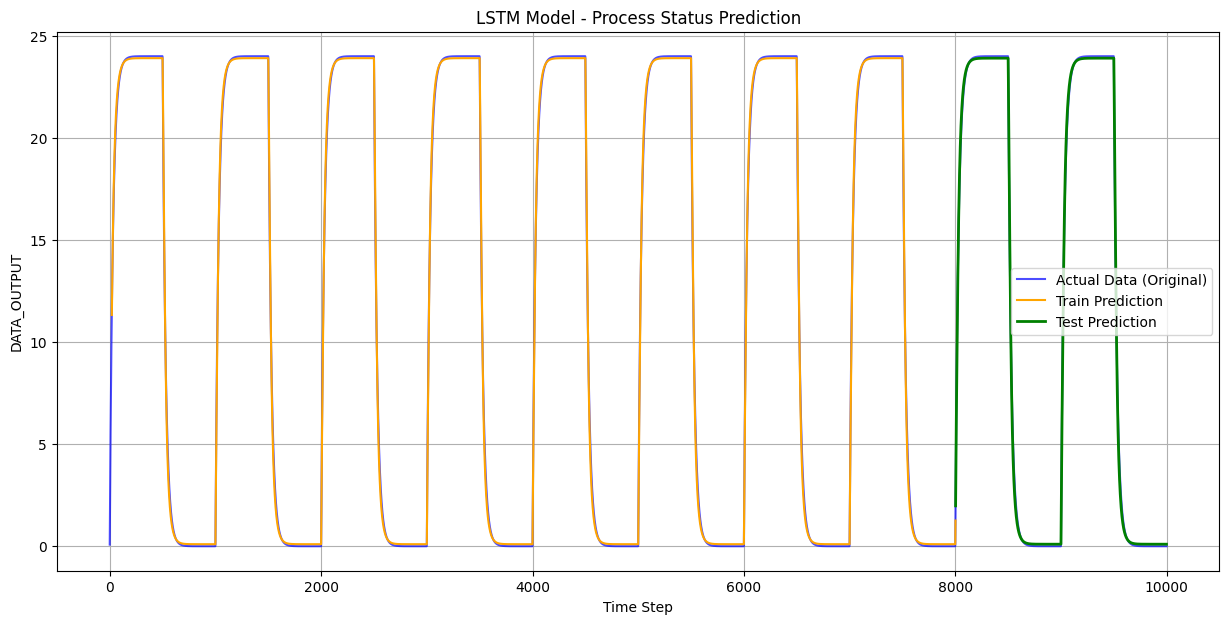


--- Project Complete ---


In [1]:
# ==============================================================================
# 0. IMPORT LIBRARIES
# ==============================================================================
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from pathlib import Path
# ==============================================================================
# 1. LOAD AND PREPARE DATA
# ==============================================================================
print("--- Step 1: Loading Data ---")
# โหลดข้อมูลจากไฟล์ CSV
try:
    df = pd.read_csv(Path(r"D:\Project_end\New_world\my_project\data\raw\pwm_duty_0.50_freq_0.01_pwm.csv"))
    print("File loaded successfully.")
    print("Data Head:")
    print(df.head())
except FileNotFoundError:
    print("Error: 'pwm_duty_0.50_freq_0.01_pwm.csv' not found.")
    print("Please make sure the file is in the same directory as the script.")
    exit()

# เลือกเฉพาะคอลัมน์ที่ต้องการใช้
data = df[['DATA_INPUT', 'DATA_OUTPUT']].values

# ==============================================================================
# 2. DATA PREPROCESSING
# ==============================================================================
print("\n--- Step 2: Preprocessing Data ---")
# 2.1 Scale Data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)
print(f"Data scaled. Shape: {scaled_data.shape}")

# 2.2 Create Sequences
def create_sequences(dataset, time_step=10):
    X, y = [], []
    for i in range(len(dataset) - time_step - 1):
        sequence = dataset[i:(i + time_step), :] 
        X.append(sequence)
        target = dataset[i + time_step, 1]
        y.append(target)
    return np.array(X), np.array(y)

# กำหนด Time Step (สามารถปรับได้)
TIME_STEP = 20
X, y = create_sequences(scaled_data, time_step=TIME_STEP)
print(f"Sequences created with TIME_STEP={TIME_STEP}")
print(f"Shape of X: {X.shape}")
print(f"Shape of y: {y.shape}")

# 2.3 Split Data into Train/Test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
print(f"Data split into {len(X_train)} training samples and {len(X_test)} testing samples.")

# 2.4 Convert to PyTorch Tensors
X_train_tensor = torch.from_numpy(X_train).float()
y_train_tensor = torch.from_numpy(y_train).float().unsqueeze(1)
X_test_tensor = torch.from_numpy(X_test).float()
y_test_tensor = torch.from_numpy(y_test).float().unsqueeze(1)
print("Data converted to PyTorch Tensors.")

# ==============================================================================
# 3. BUILD THE LSTM MODEL
# ==============================================================================
print("\n--- Step 3: Building the LSTM Model ---")
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

# Hyperparameters
INPUT_SIZE = 2
HIDDEN_SIZE = 64
NUM_LAYERS = 2
OUTPUT_SIZE = 1
LEARNING_RATE = 0.001
NUM_EPOCHS = 200

# Instantiate model, loss function, and optimizer
model = LSTMModel(INPUT_SIZE, HIDDEN_SIZE, NUM_LAYERS, OUTPUT_SIZE)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

print("Model Structure:")
print(model)

# ==============================================================================
# 4. TRAIN THE MODEL
# ==============================================================================
print("\n--- Step 4: Training the Model ---")
for epoch in range(NUM_EPOCHS):
    model.train()
    outputs = model(X_train_tensor)
    
    optimizer.zero_grad()
    loss = criterion(outputs, y_train_tensor)
    loss.backward()
    optimizer.step()
    
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{NUM_EPOCHS}], Loss: {loss.item():.6f}')
print("--- Training Finished ---")

# ==============================================================================
# 5. EVALUATE AND VISUALIZE
# ==============================================================================
print("\n--- Step 5: Evaluating and Visualizing Results ---")
model.eval()
with torch.no_grad():
    train_predict = model(X_train_tensor)
    test_predict = model(X_test_tensor)

# Inverse transform predictions to original scale
def inverse_transform_predictions(predictions, scaler):
    predictions_np = predictions.cpu().numpy()
    dummy_array = np.zeros((len(predictions_np), data.shape[1]))
    dummy_array[:, 1] = predictions_np.flatten()
    unscaled_predictions = scaler.inverse_transform(dummy_array)[:, 1]
    return unscaled_predictions

train_predict_unscaled = inverse_transform_predictions(train_predict, scaler)
test_predict_unscaled = inverse_transform_predictions(test_predict, scaler)

# --- Plotting ---
plt.figure(figsize=(15, 7))

# 1. Plot original data
original_output = df['DATA_OUTPUT'].values
plt.plot(original_output, label='Actual Data (Original)', color='blue', alpha=0.7)

# 2. Plot training predictions
train_plot_x = np.arange(TIME_STEP, len(train_predict_unscaled) + TIME_STEP)
plt.plot(train_plot_x, train_predict_unscaled, label='Train Prediction', color='orange')

# 3. Plot test predictions -- !! SECTION CORRECTED HERE !!
# คำนวณจุดเริ่มต้นของ test plot ให้ต่อจาก train plot ทันที
test_plot_start_index = len(train_predict_unscaled) + TIME_STEP
# สร้างแกน X สำหรับ test plot ให้มีขนาดเท่ากับจำนวนข้อมูลที่ทำนาย
test_plot_x = np.arange(test_plot_start_index, test_plot_start_index + len(test_predict_unscaled))
plt.plot(test_plot_x, test_predict_unscaled, label='Test Prediction', color='green', linewidth=2)


plt.title('LSTM Model - Process Status Prediction')
plt.xlabel('Time Step')
plt.ylabel('DATA_OUTPUT')
plt.legend()
plt.grid(True)
plt.show()

print("\n--- Project Complete ---")

--- Step 1: Initial Setup ---
Fitting Scaler on the entire dataset (chunk by chunk)...
Scaler has been fitted.
Counting total rows...
Total data rows found: 10000

--- Step 2: Defining Custom Dataset ---

--- Step 3: Building the LSTM Model ---

--- Step 4: Setting up DataLoaders and Model ---
Created 125 training batches and 32 testing batches.
Model Structure:
LSTMModel(
  (lstm): LSTM(2, 64, num_layers=2, batch_first=True)
  (fc): Linear(in_features=64, out_features=1, bias=True)
)

--- Step 5: Training the Model ---
Epoch [10/100], Loss: 0.000004
Epoch [20/100], Loss: 0.000007
Epoch [30/100], Loss: 0.000040
Epoch [40/100], Loss: 0.000010
Epoch [50/100], Loss: 0.000002
Epoch [60/100], Loss: 0.000004
Epoch [70/100], Loss: 0.000001
Epoch [80/100], Loss: 0.000011
Epoch [90/100], Loss: 0.000011
Epoch [100/100], Loss: 0.000001
--- Training Finished ---

--- Step 6: Evaluating and Visualizing Results ---


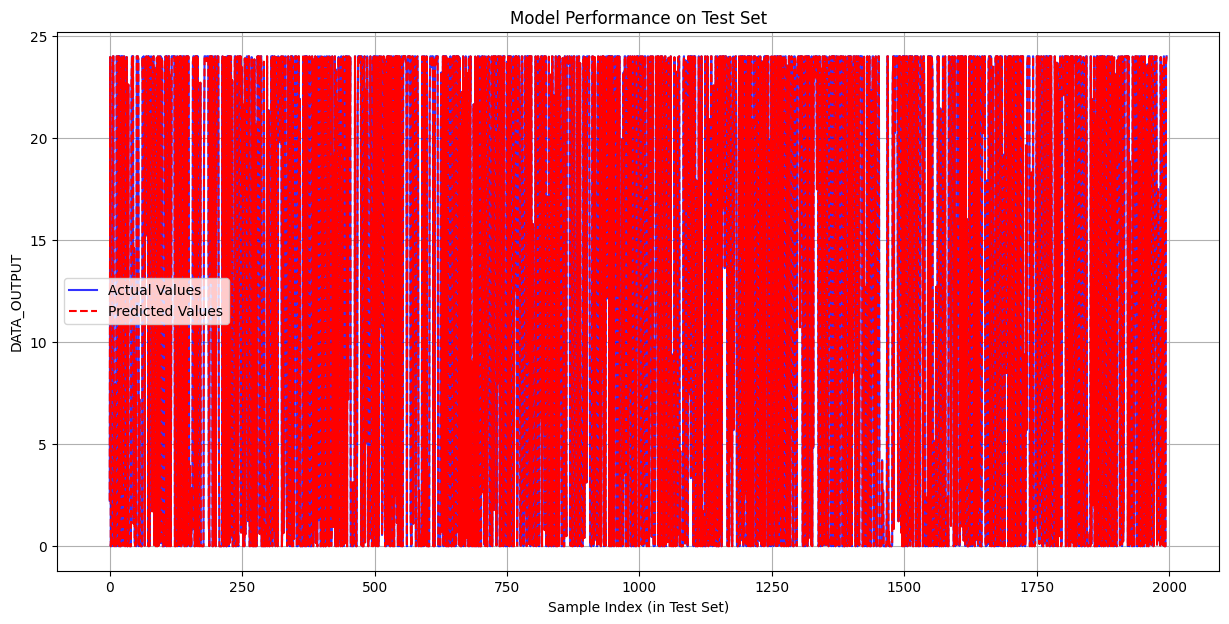


Final Mean Squared Error on Test Set: 0.000067

--- Project Complete ---


In [4]:
# ==============================================================================
# 0. IMPORT LIBRARIES
# ==============================================================================
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import Dataset, DataLoader, random_split
import matplotlib.pyplot as plt
from pathlib import Path

# ==============================================================================
# 1. INITIAL SETUP & SCALER FITTING (MEMORY EFFICIENT)
# ==============================================================================
print("--- Step 1: Initial Setup ---")
FILE_PATH = Path(r"D:\Project_end\New_world\my_project\data\raw\pwm_duty_0.50_freq_0.01_pwm.csv")

# Fit Scaler without loading the entire file into memory
# This ensures we get the correct min/max values from the whole dataset
print("Fitting Scaler on the entire dataset (chunk by chunk)...")
scaler = MinMaxScaler(feature_range=(0, 1))
chunk_size = 10000
for chunk in pd.read_csv(FILE_PATH, chunksize=chunk_size):
    # We fit on both columns to maintain the scaling context
    scaler.partial_fit(chunk[['DATA_INPUT', 'DATA_OUTPUT']].values)
print("Scaler has been fitted.")

# Count total rows for the Dataset class (memory efficient)
print("Counting total rows...")
with open(FILE_PATH) as f:
    # Subtract 1 for the header line
    num_rows = sum(1 for line in f) - 1
print(f"Total data rows found: {num_rows}")


# ==============================================================================
# 2. CUSTOM PYTORCH DATASET FOR LARGE FILES
# ==============================================================================
print("\n--- Step 2: Defining Custom Dataset ---")
class LargeCsvDataset(Dataset):
    def __init__(self, csv_path, num_rows, scaler, time_step=20):
        self.time_step = time_step
        self.scaler = scaler
        
        # Use np.loadtxt which is faster for numerical data. It reads into memory,
        # but only the necessary columns. Assumes the file can fit in RAM once reduced.
        # For truly gigantic files (>RAM), libraries like Dask or memory-mapping would be needed.
        self.data = np.loadtxt(csv_path, delimiter=',', skiprows=1, usecols=(1, 2), dtype=np.float32)

    def __len__(self):
        # The total number of sequences we can create
        return len(self.data) - self.time_step

    def __getitem__(self, idx):
        # Fetch the window of data from the numpy array
        raw_sequence_and_target = self.data[idx : idx + self.time_step + 1]
        
        # Scale the fetched window
        scaled_window = self.scaler.transform(raw_sequence_and_target)
        
        # Split into features (X) and target (y)
        X = scaled_window[:-1]      # First `time_step` entries
        y = scaled_window[-1, 1]    # The 'DATA_OUTPUT' from the last entry
        
        return torch.tensor(X, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)

# ==============================================================================
# 3. BUILD THE LSTM MODEL
# ==============================================================================
print("\n--- Step 3: Building the LSTM Model ---")
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # LSTM returns output and a tuple of the final hidden and cell states
        out, _ = self.lstm(x)
        # We take the output of the last time step to make the prediction
        out = self.fc(out[:, -1, :])
        return out

# ==============================================================================
# 4. SETUP DATALOADERS & TRAINING PARAMETERS
# ==============================================================================
print("\n--- Step 4: Setting up DataLoaders and Model ---")
# Hyperparameters
TIME_STEP = 20
BATCH_SIZE = 64
INPUT_SIZE = 2
HIDDEN_SIZE = 64
NUM_LAYERS = 2
OUTPUT_SIZE = 1
LEARNING_RATE = 0.001
NUM_EPOCHS = 100 # Reduced for demonstration, can be increased

# Create the full dataset
full_dataset = LargeCsvDataset(
    csv_path=FILE_PATH,
    num_rows=num_rows,
    scaler=scaler,
    time_step=TIME_STEP
)

# Split into training and testing sets
train_size = int(0.8 * len(full_dataset))
test_size = len(full_dataset) - train_size
train_dataset, test_dataset = random_split(full_dataset, [train_size, test_size])

# Create DataLoaders to handle batching
# shuffle=True for training to ensure model sees data in random order
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
# shuffle=False for testing to evaluate on a consistent sequence
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f"Created {len(train_loader)} training batches and {len(test_loader)} testing batches.")

# Instantiate model, loss, and optimizer
model = LSTMModel(INPUT_SIZE, HIDDEN_SIZE, NUM_LAYERS, OUTPUT_SIZE)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
print("Model Structure:")
print(model)

# ==============================================================================
# 5. TRAIN THE MODEL
# ==============================================================================
print("\n--- Step 5: Training the Model ---")
for epoch in range(NUM_EPOCHS):
    model.train()
    running_loss = 0.0
    for batch_X, batch_y in train_loader:
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y.unsqueeze(1))
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()

    if (epoch + 1) % 10 == 0:
      print(f'Epoch [{epoch+1}/{NUM_EPOCHS}], Loss: {running_loss / len(train_loader):.6f}')
print("--- Training Finished ---")

# ==============================================================================
# 6. EVALUATE AND VISUALIZE
# ==============================================================================
print("\n--- Step 6: Evaluating and Visualizing Results ---")
model.eval()
all_predictions = []
all_actuals = []

with torch.no_grad():
    for batch_X, batch_y in test_loader:
        outputs = model(batch_X)
        all_predictions.append(outputs.cpu())
        all_actuals.append(batch_y.cpu())

# Concatenate all batch results
predictions_tensor = torch.cat(all_predictions).numpy()
actuals_tensor = torch.cat(all_actuals).numpy()

# Inverse transform to get original scale
def inverse_transform_column(values, scaler, column_index=1):
    values_reshaped = values.reshape(-1, 1)
    dummy_array = np.zeros((len(values_reshaped), INPUT_SIZE))
    dummy_array[:, column_index] = values_reshaped.flatten()
    unscaled = scaler.inverse_transform(dummy_array)[:, column_index]
    return unscaled

predictions_unscaled = inverse_transform_column(predictions_tensor, scaler)
actuals_unscaled = inverse_transform_column(actuals_tensor, scaler)

# Plotting results
plt.figure(figsize=(15, 7))
plt.plot(actuals_unscaled, label='Actual Values', color='blue', alpha=0.8)
plt.plot(predictions_unscaled, label='Predicted Values', color='red', linestyle='--')
plt.title('Model Performance on Test Set')
plt.xlabel('Sample Index (in Test Set)')
plt.ylabel('DATA_OUTPUT')
plt.legend()
plt.grid(True)
plt.show()

# Calculate final test loss (optional)
test_loss = np.mean((predictions_unscaled - actuals_unscaled)**2)
print(f"\nFinal Mean Squared Error on Test Set: {test_loss:.6f}")

print("\n--- Project Complete ---")

In [ ]:
# =============================================================================
# LSTM Training with Streaming DataLoader (Memory-Efficient)
# =============================================================================

import torch
import torch.nn as nn
from torch.utils.data import IterableDataset, DataLoader
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from pathlib import Path

# =============================================================================
# Step 1: Streaming Dataset Definition
# =============================================================================
class StreamingSequenceDataset(IterableDataset):
    """
    Iterable dataset for loading large time series data from CSV file.
    Streams data in chunks (chunk_size rows at a time) and creates
    sequences for LSTM training without loading the full dataset into memory.
    """

    def __init__(self, file_path: str, seq_len: int = 50, chunk_size: int = 10000):
        """
        Args:
            file_path (str): Path to large CSV file
            seq_len (int): Sequence length for LSTM
            chunk_size (int): Number of rows read per chunk
        """
        super().__init__()
        self.file_path = Path(file_path)
        self.seq_len = seq_len
        self.chunk_size = chunk_size
        self.scaler = MinMaxScaler()  # scale each chunk independently for simplicity

    def __iter__(self):
        """
        Iterate over chunks of the dataset.
        Each chunk is transformed into overlapping sequences (X, y).
        """
        for chunk in pd.read_csv(self.file_path, chunksize=self.chunk_size):
            # Convert to numpy float32
            data = chunk.values.astype(np.float32)
            
            # Scale within chunk (for very large data, use global scaler fitted beforehand)
            data = self.scaler.fit_transform(data)
            
            # Generate sequences
            for i in range(len(data) - self.seq_len):
                X = data[i:i + self.seq_len]
                y = data[i + self.seq_len]
                yield torch.tensor(X), torch.tensor(y)


# =============================================================================
# Step 2: Define LSTM Model
# =============================================================================
class LSTM_MODEL(nn.Module):
    """
    Simple LSTM for regression or time series forecasting.
    """

    def __init__(self, input_dim, hidden_dim, num_layers, output_dim, dropout=0.2):
        super(LSTM_MODEL, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])  # use last hidden state
        return out


# =============================================================================
# Step 3: Training Configuration
# =============================================================================
def train_lstm_streaming(csv_path, seq_len=50, chunk_size=10000, batch_size=64, num_epochs=5):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Create streaming dataset & dataloader
    dataset = StreamingSequenceDataset(csv_path, seq_len=seq_len, chunk_size=chunk_size)
    loader = DataLoader(dataset, batch_size=batch_size)

    # Assume we know the number of features from one small sample
    sample_chunk = pd.read_csv(csv_path, nrows=1)
    input_dim = sample_chunk.shape[1]
    output_dim = input_dim  # predict next step of all features

    # Initialize model
    model = LSTM_MODEL(input_dim=input_dim, hidden_dim=64, num_layers=2, output_dim=output_dim).to(device)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

    # Training loop
    for epoch in range(num_epochs):
        model.train()
        epoch_loss = 0.0
        batch_count = 0

        for X_batch, y_batch in loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)

            optimizer.zero_grad()
            y_pred = model(X_batch)
            loss = criterion(y_pred, y_batch)
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()
            batch_count += 1

        avg_loss = epoch_loss / max(1, batch_count)
        print(f"Epoch [{epoch+1}/{num_epochs}] - Loss: {avg_loss:.6f}")

    print("✅ Training complete.")
    return model


# =============================================================================
# Step 4: Example Usage
# =============================================================================
if __name__ == "__main__":
    # Suppose you have a very large CSV file
    csv_path = r"D:\Project_end\New_world\my_project\data\raw\pwm_duty_0.50_freq_0.01_pwm.csv"

    # Example: Generate a fake large CSV (for demo)
    if not Path(csv_path).exists():
        n_rows = 500_000  # simulate large dataset
        n_features = 5
        data = np.random.randn(n_rows, n_features)
        pd.DataFrame(data, columns=[f"f{i}" for i in range(n_features)]).to_csv(csv_path, index=False)
        print(f"Generated demo file: {csv_path}")

    # Train LSTM with streaming
    train_lstm_streaming(csv_path, seq_len=50, chunk_size=10000, batch_size=64, num_epochs=5)


Epoch [1/5] - Loss: 0.040194
Epoch [2/5] - Loss: 0.021810
Epoch [3/5] - Loss: 0.010581
Epoch [4/5] - Loss: 0.004601
Epoch [5/5] - Loss: 0.004668
✅ Training complete.


--- Step 1: Loading Large Data Efficiently ---

--- Step 2: Preparing Streaming Data ---
Streaming DataLoader created successfully. Data will be loaded chunk-by-chunk during training.

--- Step 3: Building the LSTM Model ---
Model Structure:
LSTMModel(
  (lstm): LSTM(1, 64, num_layers=2, batch_first=True)
  (fc): Linear(in_features=64, out_features=1, bias=True)
)

--- Step 4: Training the Model ---
Epoch [1/10] | Avg Loss: 0.275980
Epoch [2/10] | Avg Loss: 0.034721
Epoch [3/10] | Avg Loss: 0.019432
Epoch [4/10] | Avg Loss: 0.015876
Epoch [5/10] | Avg Loss: 0.017404
Epoch [6/10] | Avg Loss: 0.015587
Epoch [7/10] | Avg Loss: 0.022352
Epoch [8/10] | Avg Loss: 0.019555
Epoch [9/10] | Avg Loss: 0.013386
Epoch [10/10] | Avg Loss: 0.011866
--- Training Finished ---

--- Step 5: Evaluating Model ---
Generating small preview of predictions...


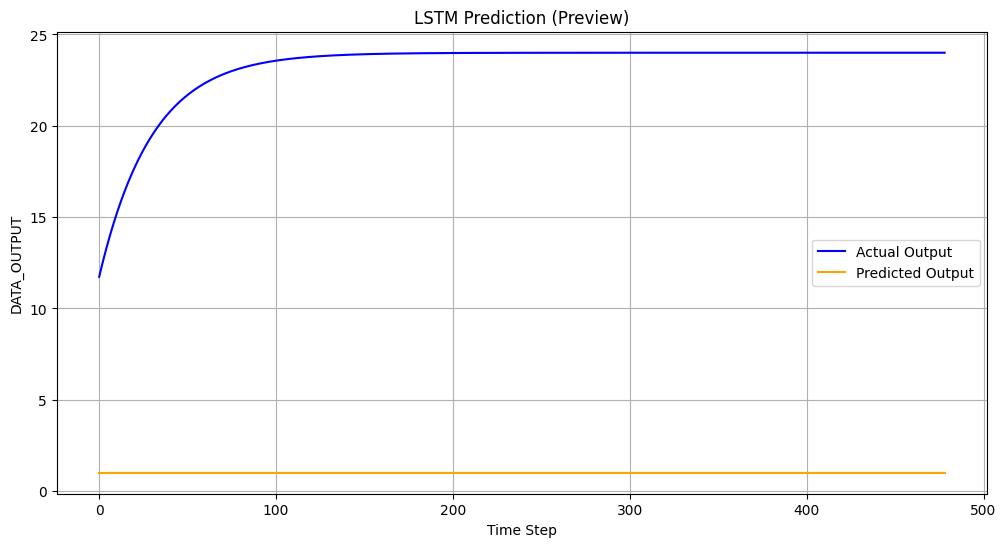


--- Project Complete ---


In [ ]:
# ==============================================================================
# 0. IMPORT LIBRARIES
# ==============================================================================
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import IterableDataset, DataLoader
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from pathlib import Path
import warnings
warnings.filterwarnings("ignore")

# ==============================================================================
# 1. LOAD AND STREAM DATA
# ==============================================================================
print("--- Step 1: Loading Large Data Efficiently ---")

class StreamingSequenceDataset(IterableDataset):
    """
    IterableDataset for streaming large CSV files chunk-by-chunk.
    Each chunk is normalized and converted into sequences for LSTM input.
    """

    def __init__(self, csv_path, input_cols, target_col, seq_len=20, chunk_size=5000):
        """
        Args:
            csv_path (str): Path to large CSV file.
            input_cols (list): Columns to be used as input features.
            target_col (str): Column name to predict.
            seq_len (int): Sequence length (time steps) for LSTM.
            chunk_size (int): Number of rows to read per chunk.
        """
        self.csv_path = Path(csv_path)
        self.input_cols = input_cols
        self.target_col = target_col
        self.seq_len = seq_len
        self.chunk_size = chunk_size
        self.scaler = MinMaxScaler(feature_range=(0, 1))

    def __iter__(self):
        # Read large CSV file in chunks
        for chunk in pd.read_csv(self.csv_path, chunksize=self.chunk_size):
            data = chunk[self.input_cols + [self.target_col]].values.astype(np.float32)
            data = self.scaler.fit_transform(data)

            X, y = [], []
            for i in range(len(data) - self.seq_len - 1):
                X.append(data[i:i + self.seq_len, :len(self.input_cols)])
                y.append(data[i + self.seq_len, len(self.input_cols)])
            
            for X_seq, y_seq in zip(X, y):
                yield torch.tensor(X_seq), torch.tensor([y_seq])


# ==============================================================================
# 2. DATA PREPARATION AND LOADER
# ==============================================================================
print("\n--- Step 2: Preparing Streaming Data ---")

# File path (change this to your actual file)
CSV_PATH = r"D:\Project_end\New_world\my_project\data\raw\pwm_duty_0.50_freq_0.01_pwm.csv"

# Choose columns
INPUT_COLS = ['DATA_INPUT']
TARGET_COL = 'DATA_OUTPUT'

# Create streaming dataset
dataset = StreamingSequenceDataset(csv_path=CSV_PATH, input_cols=INPUT_COLS, target_col=TARGET_COL, seq_len=20, chunk_size=5000)

# Wrap with DataLoader
train_loader = DataLoader(dataset, batch_size=64)

print("Streaming DataLoader created successfully. Data will be loaded chunk-by-chunk during training.")

# ==============================================================================
# 3. BUILD THE LSTM MODEL
# ==============================================================================
print("\n--- Step 3: Building the LSTM Model ---")

class LSTMModel(nn.Module):
    """
    Simple LSTM model for time series prediction.
    """

    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # Initialize hidden state and cell state
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)

        # Forward propagate LSTM
        out, _ = self.lstm(x, (h0, c0))
        # Output the last time step
        out = self.fc(out[:, -1, :])
        return out

# Hyperparameters
INPUT_SIZE = len(INPUT_COLS)
HIDDEN_SIZE = 64
NUM_LAYERS = 2
OUTPUT_SIZE = 1
LEARNING_RATE = 0.001
NUM_EPOCHS = 10

# Instantiate model, loss, optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = LSTMModel(INPUT_SIZE, HIDDEN_SIZE, NUM_LAYERS, OUTPUT_SIZE).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

print("Model Structure:")
print(model)

# ==============================================================================
# 4. TRAIN THE MODEL
# ==============================================================================
print("\n--- Step 4: Training the Model ---")
model.train()
for epoch in range(NUM_EPOCHS):
    epoch_loss = 0
    batch_count = 0

    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        optimizer.zero_grad()
        y_pred = model(X_batch)
        loss = criterion(y_pred, y_batch)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        batch_count += 1

    print(f"Epoch [{epoch+1}/{NUM_EPOCHS}] | Avg Loss: {epoch_loss / max(1, batch_count):.6f}")

print("--- Training Finished ---")

# ==============================================================================
# 5. EVALUATE AND VISUALIZE
# ==============================================================================
print("\n--- Step 5: Evaluating Model ---")
model.eval()

# (Optional) Visual test on small data subset
print("Generating small preview of predictions...")
df_small = pd.read_csv(CSV_PATH, nrows=500)
scaler = MinMaxScaler()
data_small = scaler.fit_transform(df_small[INPUT_COLS + [TARGET_COL]].values)
X_test, y_test = [], []
SEQ_LEN = 20
for i in range(len(data_small) - SEQ_LEN - 1):
    X_test.append(data_small[i:i + SEQ_LEN, :len(INPUT_COLS)])
    y_test.append(data_small[i + SEQ_LEN, len(INPUT_COLS)])
X_test = torch.tensor(np.array(X_test), dtype=torch.float32).to(device)
y_test = np.array(y_test)

with torch.no_grad():
    y_pred = model(X_test).cpu().numpy()

# Inverse transform (to original scale)
dummy = np.zeros((len(y_pred), 2))
dummy[:, 1] = y_pred.flatten()
y_pred_unscaled = scaler.inverse_transform(dummy)[:, 1]
dummy[:, 1] = y_test.flatten()
y_test_unscaled = scaler.inverse_transform(dummy)[:, 1]

plt.figure(figsize=(12, 6))
plt.plot(y_test_unscaled, label="Actual Output", color='blue')
plt.plot(y_pred_unscaled, label="Predicted Output", color='orange')
plt.title("LSTM Prediction (Preview)")
plt.xlabel("Time Step")
plt.ylabel("DATA_OUTPUT")
plt.legend()
plt.grid(True)
plt.show()

print("\n--- Project Complete ---")


Scaler loaded successfully!
Epoch [1/20] - Loss: 0.048272
Epoch [2/20] - Loss: 0.016576
Epoch [3/20] - Loss: 0.015735
Epoch [4/20] - Loss: 0.015424
Epoch [5/20] - Loss: 0.015051
Epoch [6/20] - Loss: 0.015219
Epoch [7/20] - Loss: 0.015037
Epoch [8/20] - Loss: 0.014955
Epoch [9/20] - Loss: 0.014827
Epoch [10/20] - Loss: 0.014766
Epoch [11/20] - Loss: 0.014544
Epoch [12/20] - Loss: 0.014626
Epoch [13/20] - Loss: 0.014390
Epoch [14/20] - Loss: 0.014318
Epoch [15/20] - Loss: 0.014302
Epoch [16/20] - Loss: 0.014210
Epoch [17/20] - Loss: 0.014207
Epoch [18/20] - Loss: 0.014347
Epoch [19/20] - Loss: 0.014177
Epoch [20/20] - Loss: 0.014057


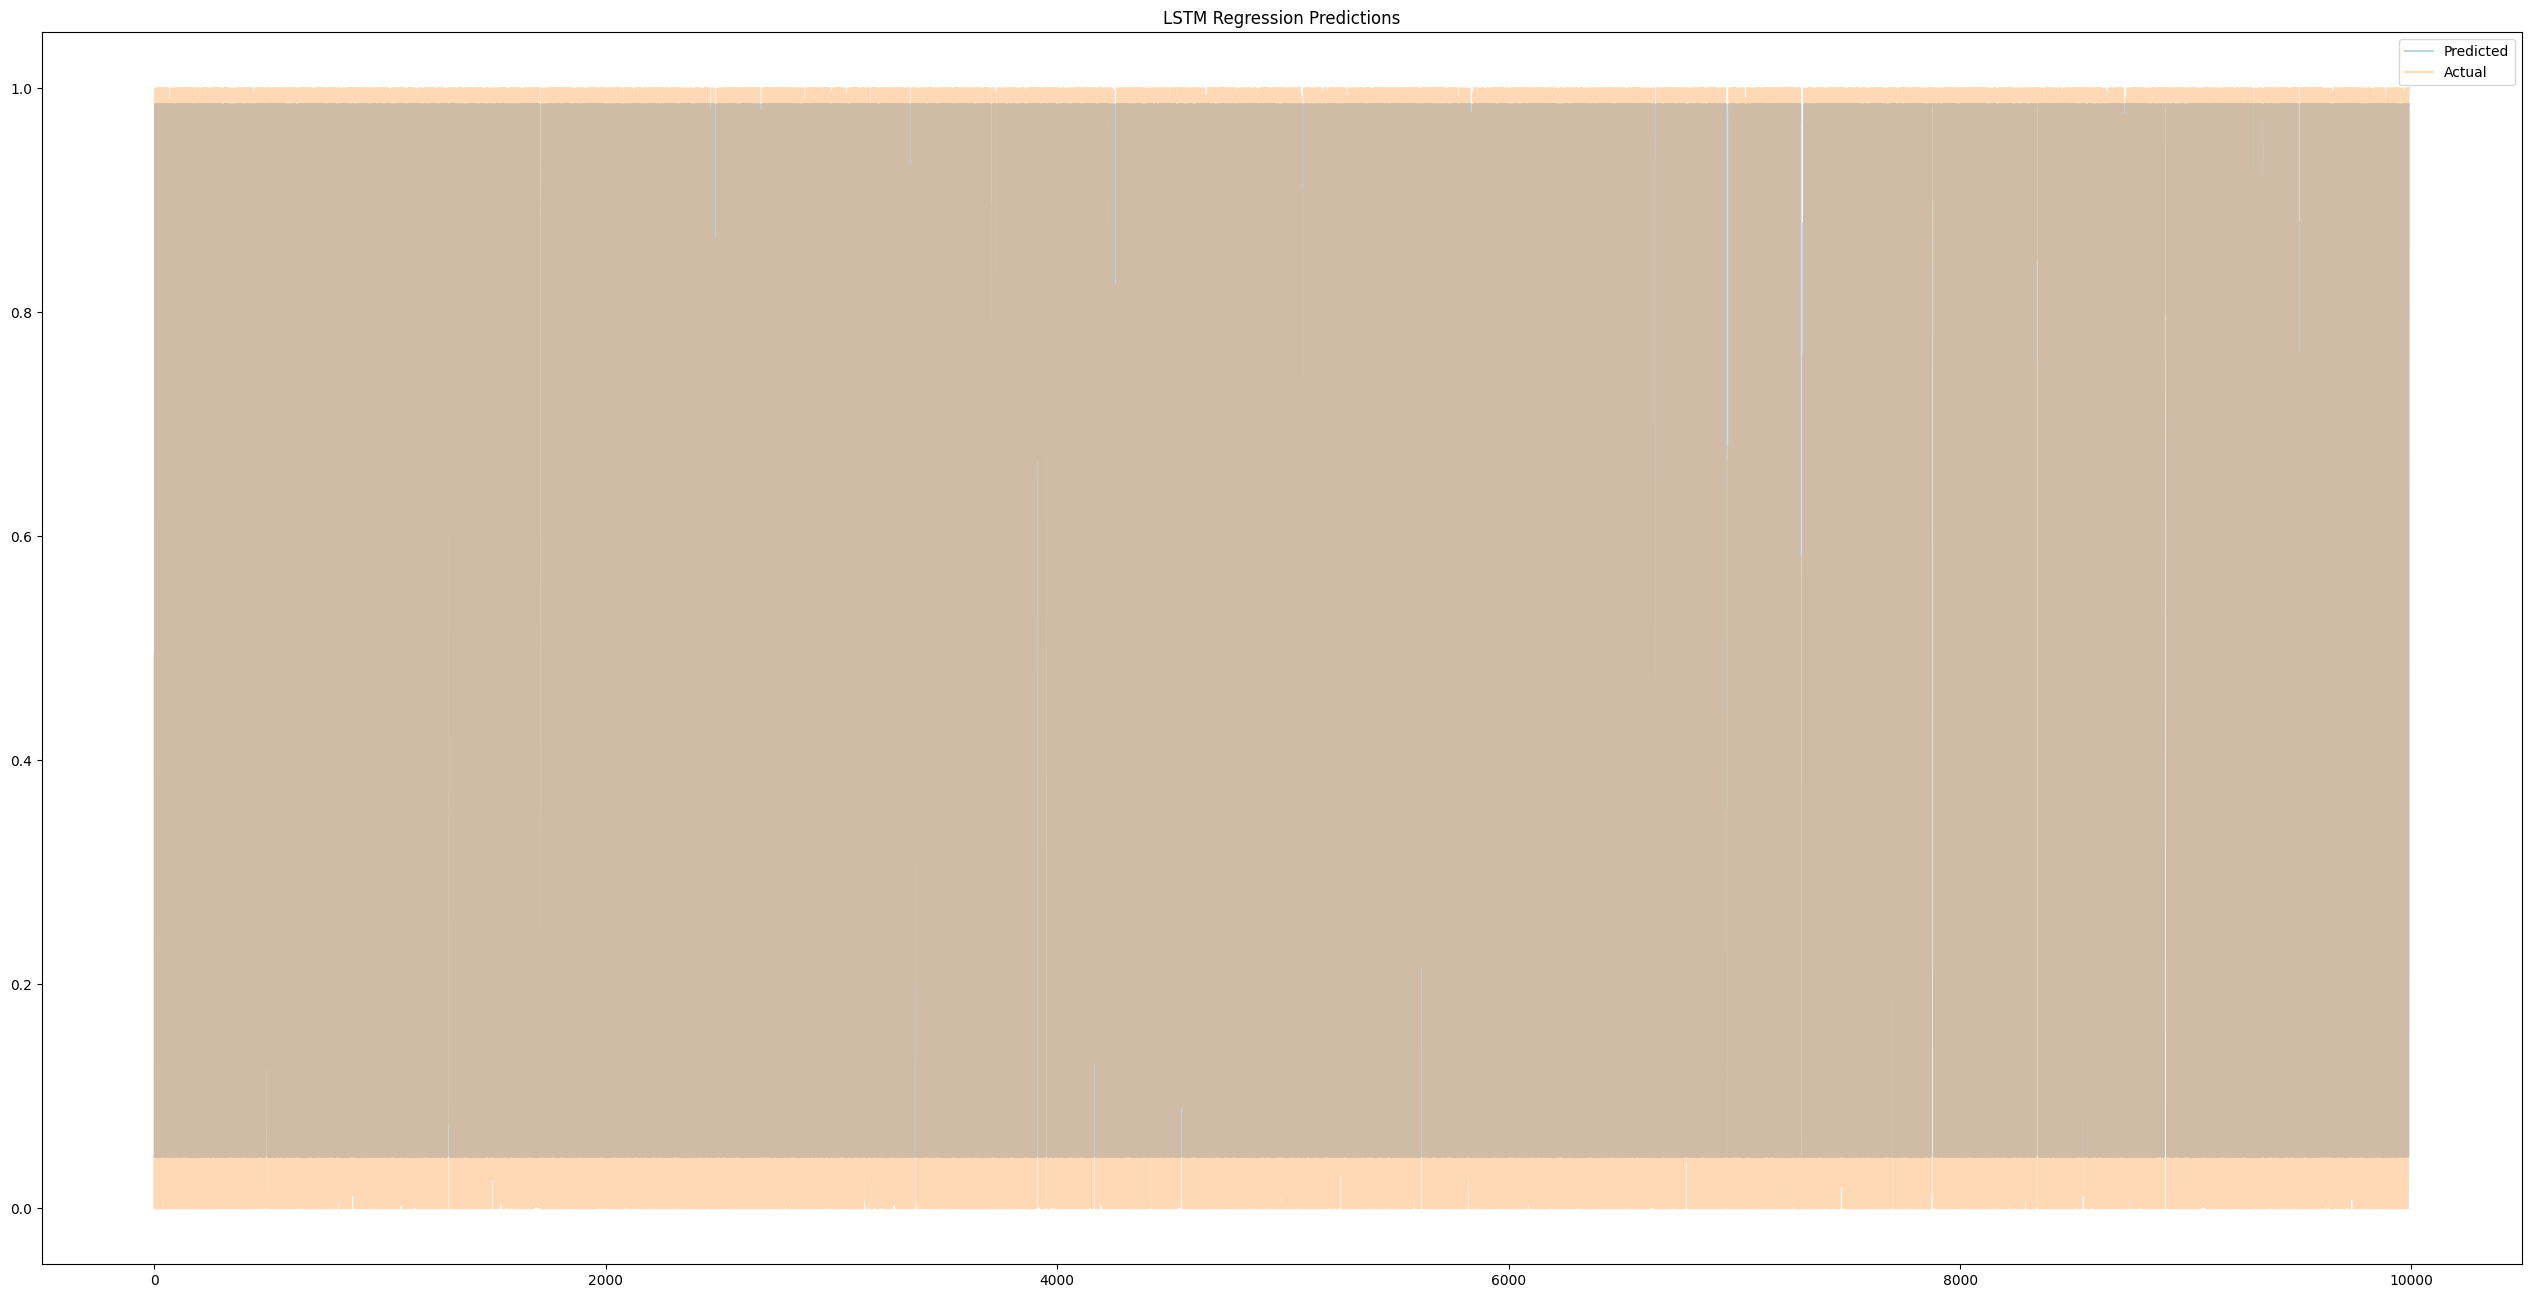

In [3]:
# train_lstm.py
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# -----------------------------
# Load Scaler from ZIP
# -----------------------------
import zipfile
import io
import joblib
import yaml
import warnings

class ScalingZipLoader:
    def __init__(self, zip_path: str | Path):
        self.zip_path = Path(zip_path)
        self.scaler_in = None
        self.scaler_out = None
        self.metadata = None

        if not self.zip_path.exists():
            raise FileNotFoundError(f"ZIP file not found: {self.zip_path}")
        self._load_from_zip()

    def _load_from_zip(self):
        with zipfile.ZipFile(self.zip_path, "r") as zipf:
            self.scaler_in = self._load_joblib_from_zip(zipf, "input_scaler.pkl")
            self.scaler_out = self._load_joblib_from_zip(zipf, "output_scaler.pkl")
            self.metadata = self._load_yaml_from_zip(zipf, "metadata.yaml")

    def _load_joblib_from_zip(self, zipf, filename):
        try:
            with zipf.open(filename) as f:
                return joblib.load(io.BytesIO(f.read()))
        except KeyError:
            raise FileNotFoundError(f"{filename} not found in ZIP")

    def _load_yaml_from_zip(self, zipf, filename):
        try:
            with zipf.open(filename) as f:
                return yaml.safe_load(f)
        except KeyError:
            warnings.warn(f"{filename} not found in ZIP", UserWarning)
            return None

    def transform_input(self, X: np.ndarray) -> np.ndarray:
        return self.scaler_in.transform(X)

    def inverse_output(self, y_scaled: np.ndarray) -> np.ndarray:
        return self.scaler_out.inverse_transform(y_scaled)

# -----------------------------
# Dataset for LSTM
# -----------------------------
class SequenceDatasetFromZip(Dataset):
    def __init__(self, csv_file, seq_len, scaler_loader, input_col='DATA_INPUT', output_col='DATA_OUTPUT'):
        self.csv_file = csv_file
        self.seq_len = seq_len
        self.scaler_loader = scaler_loader
        self.input_col = input_col
        self.output_col = output_col
        
        self.length = sum(1 for _ in open(csv_file)) - 1  # ลบ header
    
    def __len__(self):
        return self.length - self.seq_len
    
    def __getitem__(self, idx):
        df = pd.read_csv(self.csv_file, skiprows=range(1, idx+1), nrows=self.seq_len+1)
        x = df[self.input_col].values[:-1].reshape(-1, 1)
        y = df[self.output_col].values[-1]  # scalar

        # ✅ ทำ scaling
        x_scaled = self.scaler_loader.transform_input(x)
        y_scaled = self.scaler_loader.transform_input(np.array([[y]]))  # ต้องเป็น 2D

        return (
            torch.tensor(x_scaled, dtype=torch.float32),
            torch.tensor(y_scaled, dtype=torch.float32)
        )

# -----------------------------
# LSTM Model
# -----------------------------
class LSTMRegressor(nn.Module):
    def __init__(self, input_size=1, hidden_size=64, output_size=1, num_layers=1):
        super(LSTMRegressor, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        self.num_layers = num_layers
        self.hidden_size = hidden_size
    
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = out[:, -1, :]
        out = self.fc(out)
        return out

# -----------------------------
# Training Loop
# -----------------------------
def train_model(model, dataloader, device, epochs=10, lr=0.001):
    model = model.to(device)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    
    for epoch in range(1, epochs+1):
        model.train()
        running_loss = 0.0
        for x_batch, y_batch in dataloader:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            outputs = model(x_batch)
            loss = criterion(outputs, y_batch.squeeze(-1)) 
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * x_batch.size(0)
        epoch_loss = running_loss / len(dataloader.dataset)
        print(f"Epoch [{epoch}/{epochs}] - Loss: {epoch_loss:.6f}")
    return model

# -----------------------------
# Main
# -----------------------------
if __name__ == "__main__":
    # Paths
    zip_path = r"D:\Project_end\New_world\my_project\config\Test_scale1_scalers.zip"
    csv_file = r"D:\Project_end\New_world\my_project\data\raw\pwm_duty_0.50_freq_0.01_pwm.csv"

    # Load Scaler
    scaler_loader = ScalingZipLoader(zip_path)
    print("Scaler loaded successfully!")

    # Dataset + DataLoader
    seq_len = 10
    batch_size = 32
    dataset = SequenceDatasetFromZip(csv_file, seq_len, scaler_loader)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    # Device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Model
    model = LSTMRegressor(input_size=1, hidden_size=64, output_size=1, num_layers=1)

    # Train
    model = train_model(model, dataloader, device, epochs=20, lr=0.001)

    # Evaluate & Plot
    model.eval()
    preds, targets = [], []
    with torch.no_grad():
        for x_batch, y_batch in dataloader:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            outputs = model(x_batch)
            preds.append(outputs.cpu())
            targets.append(y_batch.cpu())
    preds = torch.cat(preds).numpy().squeeze()
    targets = torch.cat(targets).numpy().squeeze()

    plt.figure(figsize=(8*4,4*4))
    plt.plot(preds, label='Predicted',alpha=0.3)
    plt.plot(targets, label='Actual',alpha = 0.3)
    plt.legend()
    plt.title("LSTM Regression Predictions")
    plt.show()


In [ ]:
import os
import pandas as pd
import numpy as np
from torch.utils.data import Dataset

class ChunkedSequenceDataset(Dataset):
    def __init__(self, folder_path, seq_len, scaler_loader, input_col='DATA_INPUT', output_col='DATA_OUTPUT',
                 file_ext='.csv', chunksize=1000):
        self.seq_len = seq_len
        self.input_col = input_col
        self.output_col = output_col
        self.chunksize = chunksize
        
        self.scaler_input = scaler_loader['input']
        self.scaler_output = scaler_loader['output']
        
        self.X, self.y = self.load_files(folder_path, file_ext)
        
    def load_files(self, folder_path, file_ext):
        X_all, y_all = [], []
        files = [f for f in os.listdir(folder_path) if f.endswith(file_ext)]
        
        for file_name in files:
            file_path = os.path.join(folder_path, file_name)
            
            # อ่านไฟล์เป็น chunks
            for chunk in pd.read_csv(file_path, chunksize=self.chunksize):
                # scale input/output
                inputs = self.scaler_input.transform(chunk[[self.input_col]].values)
                outputs = self.scaler_output.transform(chunk[[self.output_col]].values)
                
                # สร้าง sequence สำหรับ chunk นี้
                X_seq, y_seq = self.create_sequences(inputs, outputs)
                
                if len(X_seq) > 0:
                    X_all.append(X_seq)
                    y_all.append(y_seq)
        
        return np.vstack(X_all), np.vstack(y_all)
    
    def create_sequences(self, X_data, y_data):
        Xs, ys = [], []
        for i in range(len(X_data) - self.seq_len):
            Xs.append(X_data[i:i+self.seq_len])
            ys.append(y_data[i+self.seq_len])
        return np.array(Xs), np.array(ys)
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]
